# Master Notebook

The aim of this notebook is to create a single strand of analysis with a coherent narrative. 

[Update the results on the Google Sheet](https://docs.google.com/spreadsheets/d/1tFsScPgzPsGqZCGhDM3cJgXysmp_lce1kUN76B2Rha8/edit?usp=sharing)

### Aim for Final Version

- Table of Vectorisation Methods * Classification Method * |Additional Methods| - Table of accuracies for different combinations of analysis methods as detailed in _Table of Analyses.xlsx_ (see `organisation/` directory)
- Explanation/Exposition of methods
- EDA - Visualise vector word representations out of different pre-processing; Basic descriptive statistics on final _input dataset_
- Clear and clean pre-processing pipeline
- Clear and clean grid search methods

### Modelling Combinations

#### Pre-processing

- Components (methods) of `CleanText`
    - In particular stemming

#### Word Representations

- Bag-of-Words - One-Hot (BOW)
    - BOW n-grams with $n > 1$
- Bag-of-Words - Frequencies (FBOW)
- Term Frequency–Inverse Document Frequency (TF-IDF)
- Word2Vec
    - Skip-grams (SG)
    - Continuous-Bag-of-Words CBOW
- FastText
- Bert

#### Classifiers

- Logistic Regression (Elastic Net)
    - Search across penalisation weights (C) and l1-l2 ratios (l1_ratio)
- Support Vector Machines (SVM)
- Naive Bayes (NB)
- Random Forests (RF)
- Gradient Boosting (GB)
- (Perceptron) (MLP)

#### Additional Modelling Considerations

- Scaled versus Unscaled data

### Questions for the Team

- Logistic Regression: Thoughts on mean accuracy as given by `LogisticRegression.score()`?
- Logistic regression was fitted on individual words previously in Felicie's notebok. Given that we have a limited number of accounts, people might have tendencies to use the same words so our low train and test errors might come from here. Stemming reduces the training and test accuracies. **We should check if the components explaining a high degree of variation are individual words used by certain accounts.**
- What should our cut-off for the minimum _document frequency_ of words be. The value 10 has been used, but 1 is the default with `CountVectorizer`.

### Messages to the Team

- The repo is public - This allows us to directly read data in by passing Pandas a URL
- You can run code via AWS as if you're working locally. Follow [this tutorial](https://chrisalbon.com/aws/basics/run_project_jupyter_on_amazon_ec2/).

### TODO

- How has Felicie's approach to BOW vectorisation been realised by `sklearn.feature_extraction.text.CountVectorizer`? In particular, has any stemming been performed and if so via which algorithm? See the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
- Which dimensions explain the most variation? Inspect model coefficients; run PCA

# Code

In [1]:
# Start Fresh

%reset -f

In [2]:
# Imports and Set Options

import csv  # for slang
import os
import re  # regex
import string  # punct
from pprint import pprint

#import emoji  # for emoji
#import gensim
#import keras
#import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
#from gensim.models import Word2Vec
from IPython.display import Image
from matplotlib import pyplot as plt
from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer  # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import svm, tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             make_scorer, plot_precision_recall_curve,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
#from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
#from sklearn.svm import SVC  # "Support vector classifier"
#from sklearn.svm import LinearSVC
#from sklearn.tree import DecisionTreeClassifier

#import xgboost as xgb

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

## Homemade Classes and Functions

In [3]:
# Clean Text Class

class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

## Read in Data and Create Train and Test Sets

In [4]:
# Read in data (Raw copy for reference; copy for processing)

tweets_raw = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


## Clean Dataset

Applies the class methods (leveraging `sklearn` API):

- translator
- remove_mentions
- remove_urls
- emoji_oneword
- possessive_pronouns
- remove_punctuation
- remove_digits
- encode_decode
- characters
- to_lower
- remove_stopwords
- stemming (via Porter Algorithm)

In [5]:
# Text Cleaning

# ct = CleanText()
# tweets["text"] = ct.fit_transform(tweets.text)
# tweets.to_csv("clean_tweets.csv") # save once processed
tweets = pd.read_csv("clean_tweets.csv") # read in instead
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

[print(dat.head(3), dat.shape, end="\n"*2) for dat in [X_train, X_test, Y_train, Y_test]];

3642     might progress climat area not enough global s...
12695    trump crackdown politic scienc nasa climat div...
8451     no one would believ human panick fals climat m...
Name: text, dtype: object (14406,)

8376     nazi root environment climat chang fraud bbcne...
6111     interest democrat candid compar mani aspect cl...
13983    ittrademark imposs see global warm signal minn...
Name: text, dtype: object (3602,)

3642     0
12695    1
8451     1
Name: label, dtype: int64 (14406,)

8376     1
6111     0
13983    1
Name: label, dtype: int64 (3602,)



In [7]:
print(f"Training label counts: \n{Y_train.value_counts()}", end="\n"*2)
print(f"Test label counts: \n{Y_test.value_counts()}")

Training label counts: 
1    8433
0    5973
Name: label, dtype: int64

Test label counts: 
1    2138
0    1464
Name: label, dtype: int64


In [8]:
# Save set of workspace objects' names to enable periodic clean-up

necessities = set(dir())

## Word Vectorisations

In [9]:
min_df = 1

### Bag of Words (BOW) Binary ("One-Hot") Representation

In [10]:
# Bag of Words Representation (One Hot, i.e. binary)

BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = min_df)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)

In [11]:
# Most frequently occurring words in the training corpus ??

[(index, word) for index, word in sorted(BOW_vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=False)][:20]

[('aaa', 0),
 ('aaand', 1),
 ('aarey', 2),
 ('aareyforest', 3),
 ('aaron', 4),
 ('aaronhuerta', 5),
 ('aaronweinschenk', 6),
 ('aayat', 7),
 ('ab', 8),
 ('abandon', 9),
 ('abat', 10),
 ('abbott', 11),
 ('abc', 12),
 ('abcashli', 13),
 ('abcaustralia', 14),
 ('abcgmw', 15),
 ('abcnew', 16),
 ('abcni', 17),
 ('abcpolit', 18),
 ('abcwtvd', 19)]

### Bag of Words with Frequencies Representation (FBOW)

In [12]:
# Bag of Words Representation (Frequencies; binary=False)

FBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                  binary=False, # Creates Word Frequency Vector; 
                                                # # np.unique(FBOW_train.toarray())
                                  min_df = min_df)
FBOW_vectorizer.fit(X_train)
FBOW_train = FBOW_vectorizer.transform(X_train)
FBOW_test = FBOW_vectorizer.transform(X_test)

In [13]:
# Word use (per tweet) frequencies

print(np.unique(FBOW_train.toarray(), return_counts=True))

# Feature_Index: Word Mapping

# {v: k for k, v in FBOW_vectorizer.vocabulary_.items()}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13], dtype=int64), array([187971908,    150063,      5514,       400,        48,         8,
               6,         2,         2,         1,         1,         1],
      dtype=int64))


### Term Frequency–Inverse Document Frequency Representation (tf-idf)

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=min_df) # used for now for consistency
tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Word2Vec - Continuous-Bag-of-Words

In [15]:
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')

## Classification

In [16]:
kfcv = KFold(n_splits=5,shuffle=True,random_state=101)

### Naive bayes Gaussian

In [17]:
clf = GaussianNB()

var_smoothing = [pow(10,k)/1000000000 for k in range(10)]

param_grid = {
           'var_smoothing': var_smoothing
        }

### Grid Search : BOW no Scale

In [18]:
clf = GaussianNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')

grid_search.fit(BOW_train.toarray(),Y_train)

print(grid_search.best_params_)

best_var_smoothing = grid_search.best_params_['var_smoothing']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.3min finished


{'var_smoothing': 0.001}


BOW Gaussian naives bayes (No Scale) Training Mean Accuracy: 0.938
BOW Gaussian naives bayes (No Scale) Test Mean Accuracy: 0.873
BOW Gaussian naives bayes (No Scale) Training (1 - Brier Score): 0.938
BOW Gaussian naives bayes (No Scale) Test (1 - Brier Score): 0.874


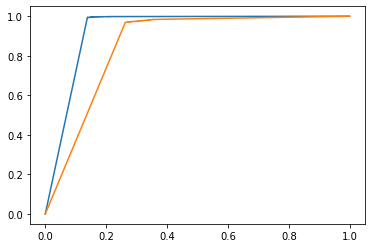

In [19]:
clf = GaussianNB(var_smoothing = best_var_smoothing).fit(BOW_train.toarray(),Y_train)

BOW_GaussianNM_noscale_accuracy_train = clf.score(BOW_train.toarray(), Y_train)
BOW_GaussianNM_noscale_accuracy_test = clf.score(BOW_test.toarray(), Y_test)

print(f"BOW Gaussian naives bayes (No Scale) Training Mean Accuracy: {np.round(BOW_GaussianNM_noscale_accuracy_train, 3)}")
print(f"BOW Gaussian naives bayes (No Scale) Test Mean Accuracy: {np.round(BOW_GaussianNM_noscale_accuracy_test, 3)}")

# Probabilities of Positive Class: Probability of Being a "Denier"

proba_train = clf.predict_proba(BOW_train.toarray())[:, 1]
proba_test = clf.predict_proba(BOW_test.toarray())[:, 1]

# Brier Scores

BOW_GaussianNM_noscale_brier_train = brier_score_loss(Y_train, proba_train)
BOW_GaussianNM_noscale_brier_test = brier_score_loss(Y_test, proba_test)

print(f"BOW Gaussian naives bayes (No Scale) Training (1 - Brier Score): {1 - round(BOW_GaussianNM_noscale_brier_train, 3)}")
print(f"BOW Gaussian naives bayes (No Scale) Test (1 - Brier Score): {1 - round(BOW_GaussianNM_noscale_brier_test, 3)}")

# ROC Curves

roc_train = roc_curve(y_true=Y_train, y_score=proba_train)

tpr_train = roc_train[0]
fpr_train = roc_train[1]
thresh_train = roc_train[2]
plt.plot(tpr_train, fpr_train);

# print(thresh_train)

roc_test = roc_curve(y_true=Y_test, y_score=proba_test)

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

# print(thresh_test)

### Grid Search : FBOW no Scale

In [20]:
clf = GaussianNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')


grid_search.fit(FBOW_train.toarray(),Y_train)
print(grid_search.best_params_)
best_var_smoothing = grid_search.best_params_['var_smoothing']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.7min finished


{'var_smoothing': 0.001}


FBOW Gaussian naives bayes (No Scale) Training Mean Accuracy: 0.929
FBOW Gaussian naives bayes (No Scale) Test Mean Accuracy: 0.868
FBOW Gaussian naives bayes (No Scale) Training (1 - Brier Score): 0.929
FBOW Gaussian naives bayes (No Scale) Test (1 - Brier Score): 0.868


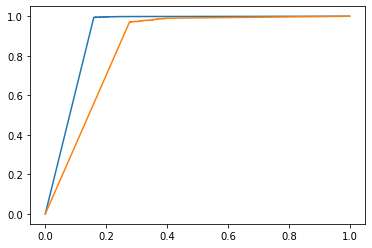

In [21]:
clf = GaussianNB(var_smoothing = best_var_smoothing).fit(FBOW_train.toarray(),Y_train)

FBOW_GaussianNM_noscale_accuracy_train = clf.score(FBOW_train.toarray(), Y_train)
FBOW_GaussianNM_noscale_accuracy_test = clf.score(FBOW_test.toarray(), Y_test)

print(f"FBOW Gaussian naives bayes (No Scale) Training Mean Accuracy: {np.round(FBOW_GaussianNM_noscale_accuracy_train, 3)}")
print(f"FBOW Gaussian naives bayes (No Scale) Test Mean Accuracy: {np.round(FBOW_GaussianNM_noscale_accuracy_test, 3)}")

# Probabilities of Positive Class: Probability of Being a "Denier"

proba_train = clf.predict_proba(FBOW_train.toarray())[:, 1]
proba_test = clf.predict_proba(FBOW_test.toarray())[:, 1]

# Brier Scores

FBOW_GaussianNM_noscale_brier_train = brier_score_loss(Y_train, proba_train)
FBOW_GaussianNM_noscale_brier_test = brier_score_loss(Y_test, proba_test)

print(f"FBOW Gaussian naives bayes (No Scale) Training (1 - Brier Score): {1 - round(FBOW_GaussianNM_noscale_brier_train, 3)}")
print(f"FBOW Gaussian naives bayes (No Scale) Test (1 - Brier Score): {1 - round(FBOW_GaussianNM_noscale_brier_test, 3)}")

# ROC Curves

roc_train = roc_curve(y_true=Y_train, y_score=proba_train)

tpr_train = roc_train[0]
fpr_train = roc_train[1]
thresh_train = roc_train[2]
plt.plot(tpr_train, fpr_train);

# print(thresh_train)

roc_test = roc_curve(y_true=Y_test, y_score=proba_test)

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

# print(thresh_test)

### Grid Search : FBOW Scaled

In [22]:
scaler = MaxAbsScaler()
FBOW_train = scaler.fit_transform(FBOW_train)
FBOW_test = scaler.transform(FBOW_test)

In [23]:
clf = GaussianNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')


grid_search.fit(FBOW_train.toarray(),Y_train)
print(grid_search.best_params_)
best_var_smoothing = grid_search.best_params_['var_smoothing']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.4min finished


{'var_smoothing': 0.001}


FBOW Gaussian naives bayes (Scale) Training Mean Accuracy: 0.935
FBOW Gaussian naives bayes (Scale) Test Mean Accuracy: 0.85
FBOW Gaussian naives bayes (Scale) Training (1 - Brier Score): 0.935
FBOW Gaussian naives bayes (Scale) Test (1 - Brier Score): 0.85


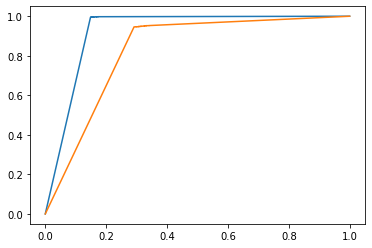

In [24]:
clf = GaussianNB(var_smoothing = best_var_smoothing).fit(FBOW_train.toarray(),Y_train)

FBOW_GaussianNM_scale_accuracy_train = clf.score(FBOW_train.toarray(), Y_train)
FBOW_GaussianNM_scale_accuracy_test = clf.score(FBOW_test.toarray(), Y_test)

print(f"FBOW Gaussian naives bayes (Scale) Training Mean Accuracy: {np.round(FBOW_GaussianNM_scale_accuracy_train, 3)}")
print(f"FBOW Gaussian naives bayes (Scale) Test Mean Accuracy: {np.round(FBOW_GaussianNM_scale_accuracy_test, 3)}")

# Probabilities of Positive Class: Probability of Being a "Denier"

proba_train = clf.predict_proba(FBOW_train.toarray())[:, 1]
proba_test = clf.predict_proba(FBOW_test.toarray())[:, 1]

# Brier Scores

FBOW_GaussianNM_scale_brier_train = brier_score_loss(Y_train, proba_train)
FBOW_GaussianNM_scale_brier_test = brier_score_loss(Y_test, proba_test)

print(f"FBOW Gaussian naives bayes (Scale) Training (1 - Brier Score): {1 - round(FBOW_GaussianNM_scale_brier_train, 3)}")
print(f"FBOW Gaussian naives bayes (Scale) Test (1 - Brier Score): {1 - round(FBOW_GaussianNM_scale_brier_test, 3)}")

# ROC Curves

roc_train = roc_curve(y_true=Y_train, y_score=proba_train)

tpr_train = roc_train[0]
fpr_train = roc_train[1]
thresh_train = roc_train[2]
plt.plot(tpr_train, fpr_train);

# print(thresh_train)

roc_test = roc_curve(y_true=Y_test, y_score=proba_test)

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

# print(thresh_test)

### GridSearch : TF_IDF No Scale

In [25]:
clf = GaussianNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')



grid_search.fit(tfidf_train.toarray(),Y_train)
print(grid_search.best_params_)
best_var_smoothing = grid_search.best_params_['var_smoothing']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.7min finished


{'var_smoothing': 0.01}


TFIDF Gaussian naives bayes (No Scale) Training Mean Accuracy: 0.959
TFIDF Gaussian naives bayes (No Scale) Test Mean Accuracy: 0.892
TFIDF Gaussian naives bayes (No Scale) Training (1 - Brier Score): 0.959
TFIDF Gaussian naives bayes (No Scale) Test (1 - Brier Score): 0.892


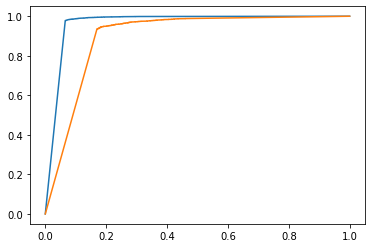

In [26]:
clf = GaussianNB(var_smoothing = best_var_smoothing).fit(tfidf_train.toarray(),Y_train)

TFIDF_GaussianNM_noscale_accuracy_train = clf.score(tfidf_train.toarray(), Y_train)
TFIDF_GaussianNM_noscale_accuracy_test = clf.score(tfidf_test.toarray(), Y_test)

print(f"TFIDF Gaussian naives bayes (No Scale) Training Mean Accuracy: {np.round(TFIDF_GaussianNM_noscale_accuracy_train, 3)}")
print(f"TFIDF Gaussian naives bayes (No Scale) Test Mean Accuracy: {np.round(TFIDF_GaussianNM_noscale_accuracy_test, 3)}")

# Probabilities of Positive Class: Probability of Being a "Denier"

proba_train = clf.predict_proba(tfidf_train.toarray())[:, 1]
proba_test = clf.predict_proba(tfidf_test.toarray())[:, 1]

# Brier Scores

TFIDF_GaussianNM_noscale_brier_train = brier_score_loss(Y_train, proba_train)
TFIDF_GaussianNM_noscale_brier_test = brier_score_loss(Y_test, proba_test)

print(f"TFIDF Gaussian naives bayes (No Scale) Training (1 - Brier Score): {1 - round(TFIDF_GaussianNM_noscale_brier_train, 3)}")
print(f"TFIDF Gaussian naives bayes (No Scale) Test (1 - Brier Score): {1 - round(TFIDF_GaussianNM_noscale_brier_test, 3)}")

# ROC Curves

roc_train = roc_curve(y_true=Y_train, y_score=proba_train)

tpr_train = roc_train[0]
fpr_train = roc_train[1]
thresh_train = roc_train[2]
plt.plot(tpr_train, fpr_train);

# print(thresh_train)

roc_test = roc_curve(y_true=Y_test, y_score=proba_test)

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

# print(thresh_test)

### TF_IDF Scaled

In [27]:
scaler = MaxAbsScaler()
tfidf_train = scaler.fit_transform(tfidf_train)
tfidf_test = scaler.transform(tfidf_test)

In [28]:
clf = GaussianNB()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                           cv=kfcv,n_jobs = -1, verbose =2, scoring='accuracy')



grid_search.fit(tfidf_train.toarray(),Y_train)
print(grid_search.best_params_)
best_var_smoothing = grid_search.best_params_['var_smoothing']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.8min finished


{'var_smoothing': 0.01}


TFIDF Gaussian naives bayes (No Scale) Training Mean Accuracy: 0.949
TFIDF Gaussian naives bayes (No Scale) Test Mean Accuracy: 0.849
TFIDF Gaussian naives bayes (No Scale) Training (1 - Brier Score): 0.949
TFIDF Gaussian naives bayes (No Scale) Test (1 - Brier Score): 0.85


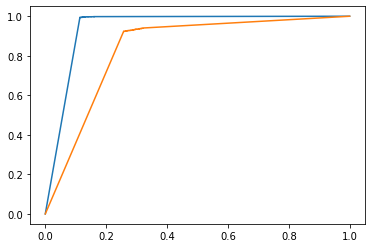

In [29]:
clf = GaussianNB(var_smoothing = best_var_smoothing).fit(tfidf_train.toarray(),Y_train)

TFIDF_GaussianNM_scale_accuracy_train = clf.score(tfidf_train.toarray(), Y_train)
TFIDF_GaussianNM_scale_accuracy_test = clf.score(tfidf_test.toarray(), Y_test)

print(f"TFIDF Gaussian naives bayes (Scale) Training Mean Accuracy: {np.round(TFIDF_GaussianNM_scale_accuracy_train, 3)}")
print(f"TFIDF Gaussian naives bayes (Scale) Test Mean Accuracy: {np.round(TFIDF_GaussianNM_scale_accuracy_test, 3)}")

# Probabilities of Positive Class: Probability of Being a "Denier"

proba_train = clf.predict_proba(tfidf_train.toarray())[:, 1]
proba_test = clf.predict_proba(tfidf_test.toarray())[:, 1]

# Brier Scores

TFIDF_GaussianNM_scale_brier_train = brier_score_loss(Y_train, proba_train)
TFIDF_GaussianNM_scale_brier_test = brier_score_loss(Y_test, proba_test)

print(f"TFIDF Gaussian naives bayes (Scale) Training (1 - Brier Score): {1 - round(TFIDF_GaussianNM_scale_brier_train, 3)}")
print(f"TFIDF Gaussian naives bayes (Scale) Test (1 - Brier Score): {1 - round(TFIDF_GaussianNM_scale_brier_test, 3)}")

# ROC Curves

roc_train = roc_curve(y_true=Y_train, y_score=proba_train)

tpr_train = roc_train[0]
fpr_train = roc_train[1]
thresh_train = roc_train[2]
plt.plot(tpr_train, fpr_train);

# print(thresh_train)

roc_test = roc_curve(y_true=Y_test, y_score=proba_test)

tpr_test = roc_test[0]
fpr_test = roc_test[1]
thresh_test = roc_test[2]
plt.plot(tpr_test, fpr_test); 

# print(thresh_test)

### ROC curve to compare our models' accuracy

lin_roc_auc = roc_auc_score(Y_test, model_SVM_l1.predict(X_test))
fpr_lin, tpr_lin, thresholds_lin = roc_curve(Y_test, model_SVM_l1.predict_proba(X_test)[:,1])

g_roc_auc = roc_auc_score(Y_test, model_SVM_l1_g.predict(X_test))
fpr_g, tpr_g, thresholds_g = roc_curve(Y_test, model_SVM_l1_g.predict_proba(X_test)[:,1])

lin_roc_auc_max = roc_auc_score(Y_test, model_SVM_max.predict(X_test))
fpr_lmax, tpr_lmax, thresholds_lmax = roc_curve(Y_test, model_SVM_max.predict_proba(X_test)[:,1])

g_roc_auc_max = roc_auc_score(Y_test, model_SVM_max_g.predict(X_test))
fpr_gmax, tpr_gmax, thresholds_gmax = roc_curve(Y_test, model_SVM_max_g.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr_lin, tpr_lin, label='Linear model (area = %0.2f)' % lin_roc_auc)
plt.plot(fpr_g, tpr_g, label='Gaussian model (area = %0.2f)' % g_roc_auc)
plt.plot(fpr_lmax, tpr_lmax, label='Best linear model (area = %0.2f)' % lin_roc_auc_max)
plt.plot(fpr_gmax, tpr_gmax, label='Best gaussian model (area = %0.2f)' % g_roc_auc_max)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model comparaison')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Variations coefficients : 

score_lin = cross_val_score(model_SVM_l1, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_best_lin = cross_val_score(model_SVM_max, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_best_gauss = cross_val_score(model_SVM_max_g, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_gauss = cross_val_score(model_SVM_l1_g, X_train, Y_train, cv = 5, scoring = 'accuracy')

name = np.array(['linear model']+['best linear model']+['gaussian model']+['best gaussian model'])
L_2 = [name,np.array([np.mean(score_lin),np.mean(score_best_lin),np.mean(score_gauss),np.mean(score_best_gauss)])]
score_model = pd.DataFrame()
score_model[""], score_model["Score with 5 fold CV"]= [L_2[0],L_2[1]]
print(score_model)